In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from random import sample
import tensorflow as tf
from tensorflow import keras, losses
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.metrics import silhouette_score
import cv2
from sklearn import mixture
from sklearn.cluster import SpectralClustering, DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from scipy.spatial import procrustes
from scipy.spatial import distance
from matplotlib.patches import Circle
from sklearn.model_selection import ParameterGrid
import statistics
import math
from skimage.morphology import skeletonize
from sklearn.mixture import GaussianMixture
from scipy.interpolate import CubicSpline
from IPython import display
import glob
import imageio
import PIL
import tensorflow_probability as tfp
import time
from tqdm import tqdm
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage import data, img_as_float

Prepare Omniglot Dataset

In [ ]:
size = 105
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [size, size])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

        #self.alpha = list(self.data.keys())


    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, size, size, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, size, size, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

ds = tfds.load("omniglot", split="train", as_supervised=False)

label_alphabet = {}

for i in ds:
    alphabet_str = str(i['alphabet'].numpy())
    label = i['label'].numpy()

    if alphabet_str not in label_alphabet:
        label_alphabet[alphabet_str] = []

    label_alphabet[alphabet_str].append(label)

Prepare Alphabets

In [ ]:
for i in ds:
    alphabet_str = str(i['alphabet'].numpy())
    label = i['label'].numpy()

    if alphabet_str not in label_alphabet:
        label_alphabet[alphabet_str] = []

    label_alphabet[alphabet_str].append(label)

alphabets = [i for i in label_alphabet.keys()]
# print(alphabets)
#['27', '30', '17', '12', '15', '37', '43', '48', '32', '3', '2', '21', '25', '13', '14', '35', '26', '20', '0', '38', '4', '16', '41', '24', '11', '10', '31', '5', '45', '22']


all_alphabets = [] #all_alphabets contain the classes for each alphabet
for id in alphabets:
  alpha = [str(i) for i in np.unique(label_alphabet[id])]
  all_alphabets.append(alpha)

#Extracts n different characters from the same alphabet
def n_chars_from_alphabet(n,alphabet):
  images = []
  labels = sample(alphabet,n)
  for i in labels:
    image = train_dataset.data[str(i)][np.random.randint(len(train_dataset.data[str(i)]))] #takes first example
    image = np.stack((image[:, :, 0],) * 3, axis=2)
    image *= 255
    image = np.clip(image, 0, 255).astype("uint8")
    images.append(image)

  return images, [str(i) for i in labels]

Necessary Functions

In [ ]:
sample_keys = list(train_dataset.data.keys())## Visualize some examples from the dataset

#Converts the raw image to cartesian coordinates
#Returns xy values (n, 2)


def plot(xy, labels):
  plt.subplots()
  plt.scatter(xy[:, 0], xy[:, 1], c=labels, s=40, cmap='viridis')


#use with scale shift
def plot_xy(xy):
  plt.scatter(xy[:, 0], xy[:, 1])


#Returns optimal number of clusters & every xy's cluster label
def sil_scores(xy):
  n_clusters = range_of_n
  scores = []
  for i in n_clusters:
    labelsi = mixture.GaussianMixture(n_components=i, random_state = 42).fit(xy).predict(xy) #training x & y
    score = silhouette_score(xy,labelsi)
    scores.append(score)

  best_n_comp = n_clusters[np.argmax(scores)]
  best_n_labels = mixture.GaussianMixture(n_components=best_n_comp, random_state = 42).fit(xy).predict(xy)
  # print("Best N", best_n_comp)
  return best_n_comp


def generate(xy, n, density): #generates scatter samples of the character
  gen = mixture.GaussianMixture(n_components= n, random_state=42).fit(xy)
  newwxy, newlabels = gen.sample(density)
  newxy = newwxy[:,:2]
  return newlabels, newxy


def centroid(xy, n): #sorted centroids based on x value and then y
  gen = mixture.GaussianMixture(n_components= n, random_state = 42).fit(xy)
  newwxy, newlabels = gen.sample(density_of_generated_pixels)
  newxy = newwxy[:,:2]
  categories = np.unique(newlabels)
  unsorted_centroids_dict = {}
  for cat in categories:
    index_per_category = [i for i, x in enumerate(newlabels) if x == cat]
    xy2 = newxy[index_per_category] #only the coordinates of each category
    mean = np.mean(xy2, axis = 0)
    unsorted_centroids_dict[cat] = mean
  plt.scatter(mean[0],mean[1], cmap = 'red')
  plt.show()

  unsorted_centroid_coordinates = [] #list of centroid XY coords
  for i in unsorted_centroids_dict.values():
    unsorted_centroid_coordinates.append(i)

  centroids = sorted(unsorted_centroid_coordinates, key=lambda x: (x[0], x[1]))

  return centroids


def character(char_class, example1_index, example2_index): #outputs two examples of the same class
  a = train_dataset.data[str(char_class)][example1_index]
  a = np.stack((a[:, :, 0],) * 3, axis=2)
  a *= 255
  a = np.clip(a, 0, 255).astype("uint8")
  a = pix2cart(a)
  # a = np.unique(a, axis=0)
  a1 = train_dataset.data[str(char_class)][example2_index]
  a1 = np.stack((a1[:, :, 0],) * 3, axis=2)
  a1 *= 255
  a1 = np.clip(a1, 0, 255).astype("uint8")
  a1 = pix2cart(a1)
  # a1 = np.unique(a1, axis=0)
  return a, a1


def cart2pix(generated_a): #converts generated characters back into images to feed into the neural network
  # Find the maximum value of x and y in the array
  max_x, max_y = np.amax(generated_a, axis=0)
  # Scale the XY coordinates to fit within the 28x28 pixel grid
  scaled_coordinates = np.round(np.array(generated_a) * (28 / max(max_x, max_y))).astype(int)
  scaled_coordinates = np.clip(scaled_coordinates, 0, 27)
  # Create an empty image with all pixels set to 0
  image = np.zeros((28, 28))
  # Set the pixel values at the scaled XY coordinates to 1
  image[scaled_coordinates[:, 0], scaled_coordinates[:, 1]] = 1
  return image


def oneshot(n): # n = N way
  #_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
  sample_keys = list(train_dataset.data.keys())
  selected_classes = random.sample(sample_keys, n)
  query_class = random.sample(selected_classes,1)
  char_idx = np.random.randint(20) #bc there are 20 examples per class/character
  query = train_dataset.data[query_class[0]][char_idx]
  query = np.stack((query[:, :, 0],) * 3, axis=2)
  query *= 255
  query = np.clip(query, 0, 255).astype("uint8")
  comparisons = [] #the other example candidates to compare against the query

  # Iterate through the selected classes
  for i, selected_class in enumerate(selected_classes):
    # Get a random sample of an image from the class
    comp_idx = np.random.randint(20)
    temp_image = train_dataset.data[selected_class][comp_idx]
    temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    comparisons.append(temp_image)

  return query,query_class,comparisons,selected_classes


# returns intersections wrt to each candidate (red)
from scipy.spatial import KDTree
def find_too_close(blu, red, radius):
    treeblu = KDTree(blu)
    treered = KDTree(red)
    distblu, idxblu = treeblu.query(red, k=1, distance_upper_bound=radius * 2)
    nonintersectingblu = np.nonzero(distblu > 2 * radius)[0]
    intersectingblu = np.nonzero(distblu <= 2 * radius)[0]
    distred, idxred = treered.query(blu, k=1, distance_upper_bound=radius * 2)
    nonintersectingred = np.nonzero(distred > 2 * radius)[0]
    intersectingred = np.nonzero(distred <= 2 * radius)[0]
    outliers = len(nonintersectingred) + len(nonintersectingblu)
    intersection = min(len(intersectingblu),len(intersectingred))
    score = intersection - 1.4*outliers
    return score


#Scale and shift code
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale_shift(xy): #shifts all data to center and scales by min max normalization
  scaler = MinMaxScaler(feature_range=(0, 28),clip=True)
  # scaler = StandardScaler()
  xy = scaler.fit_transform(xy)
  centroid = np.mean(xy,axis = 0)
  centroid_x = centroid[0]
  centroid_y = centroid[1]
  center_x = 0
  center_y = 0
  x_shift = center_x - centroid_x
  y_shift = center_x - centroid_y
  centered_x = list(i[0] for i in xy) + x_shift
  centered_y = list(i[1] for i in xy) + y_shift
  centered_xy = [[i, j] for i, j in zip(centered_x, centered_y)]

  return np.array(centered_xy)


# visualize the circles
def mapping_plot(xy1, xy2, radius): #xy1 is the query (blue), xy2 is the comparison
  xy1=scale_shift(xy1)
  xy2=scale_shift(xy2)

  # return xy1, xy2
######################### Visualizations #############################
  # plt.ylim(-5,40)
  # plt.xlim(-5,40)
  plt.scatter(xy1[:, 0], xy1[:, 1], c="b")
  plt.scatter(xy2[:, 0], xy2[:, 1], c="r")
  n_query = len(xy1)
  n_compared = len(xy2)

  for j in range(n_query):
    circle = plt.Circle(xy1[j], radius, color='b', fill=False)
    plt.gca().add_artist(circle)
  for i in range(n_compared):
    circle = plt.Circle(xy2[i], radius, color='r', fill=False)
    plt.gca().add_artist(circle)
######################### Visualizations #############################



def rotate(points, angle):
    """Rotate a list of points around a center point by a given angle (in radians)"""
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotation_matrix = np.array([[cos_angle, -sin_angle],
                                [sin_angle, cos_angle]])

    center = np.array(np.mean(points, axis = 0))
    # Translate the points so that the center point is at the origin
    translated_points = points - center

    # Apply the rotation matrix to the translated points
    rotated_points = translated_points.dot(rotation_matrix)

    # Translate the rotated points back to the original coordinate system
    translated_rotated_points = rotated_points + center

    return translated_rotated_points

def wiggle(xy):
  shiftu = xy + [0,3]
  shiftd = xy + [0,-3]
  shiftl = xy + [-3,0]
  shiftr = xy + [3,0]

  rotate20l = rotate(xy,math.radians(-15))
  rotate20r = rotate(xy,math.radians(15))
  rotate40l = rotate(xy,math.radians(-25))
  rotate40r = rotate(xy,math.radians(25))
  return xy,shiftu,shiftd,shiftl,shiftr,rotate20l,rotate20r,rotate40l,rotate40r

def pix2cart(image):
  t = max(np.unique(image))/2
  xy = np.stack(np.where(image<t)).transpose()
  xy = xy[:,:2]
  xy = list(set([tuple(i) for i in xy]))
  xy = [list(i) for i in xy]
  return xy


def skel(xy):
  i = cart2pix(xy)
  i = skeletonize(i)
  i = np.stack(np.where(i>0.5)).transpose()
  i = i[:,:2]
  i = list(set([tuple(j) for j in i]))
  i = [list(j) for j in i]
  i = np.array(i)
  n = 10
  try:
    gmm = GaussianMixture(n_components= n)
  except:
    n -= 1

  labels = gmm.fit_predict(np.array(i))
  plt.scatter(np.array(i)[:,0],np.array(i)[:,1],c = labels)
  return np.array(i), labels, gmm, n

def synt_char(image, n_examples,density): #returns n different examples of a single character
  #Feed in image data
  #Outputs a list of shape (n,300,2)
  synt_data = []
  range_n = [6,7,8,9,10]
  probabilities = [.1,.1,.2,.3,.3]
  for i in range(n_examples):
    current_n = np.random.choice(range_n,p = probabilities)
    a1 = pix2cart(image)
    gmm = GaussianMixture(n_components=current_n).fit(a1)
    a2,labels = gmm.sample(density)
    a3 = np.array(a2)
    synt_data.append(a3)
  return synt_data,labels #xy coords

def synt_alphabet(alphabet,n_examples,density): #Feed in a list of characters from an alphabet if 10 characters --> (10,100,300,2)
  synthetic_characters = []
  labelz = []
  for char in tqdm(alphabet):
    sc,labels = synt_char(char,n_examples,density)
    synthetic_characters.extend(sc)
    labelz.append(labels)
  return synthetic_characters,labelz

def oneshot_within(n,alphabet,visual = False): # n-way different characters from single alphabet

  if visual == True:
############### VISUALIZATIONS ######################
    if n == 5: #5 way
      _, axarr = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
    else: #20 way
      _, axarr = plt.subplots(nrows=4, ncols=5, figsize=(10, 10))
############### VISUALIZATIONS ######################

  images, labels = n_chars_from_alphabet(n,alphabet)
  selected_classes = labels
  query_class = random.sample(selected_classes,1)
  query = train_dataset.data[query_class[0]][1]
  query = np.stack((query[:, :, 0],) * 3, axis=2)
  query *= 255
  query = np.clip(query, 0, 255).astype("uint8")
  comparisons = images #the other example candidates to compare against the query

############### VISUALIZATIONS ######################
  if visual == True:
    for i in range(len(selected_classes)):
      if n == 5:
        axarr[i].set_title("Class : " + selected_classes[i])
        axarr[i].imshow(images[i], cmap="gray")
        axarr[i].xaxis.set_visible(True)
        axarr[i].yaxis.set_visible(True)
      else:
        axarr[i // 5, i % 5].set_title("Class : " + selected_classes[i])
        axarr[i // 5, i % 5].imshow(images[i], cmap="gray")
        axarr[i // 5, i % 5].xaxis.set_visible(True)
        axarr[i // 5, i % 5].yaxis.set_visible(True)

    plt.show()
############### VISUALIZATIONS ######################


  return query,query_class,comparisons,selected_classes

def wiggle_comp(xy): #whole query
  l = []
  for i in xy:
    a = len()
  shiftu = xy + np.array([0,1.5])
  shiftd = xy + np.array([0,-1.5])
  shiftl = xy + np.array([-1.5,0])
  shiftr = xy + np.array([1.5,0])

  return xy,shiftu,shiftd,shiftl,shiftr


def wiggle_comp(xy,labels):
  final = []
  components = np.unique(labels)
  for c in components:
    mask = (labels == c)
    xy1 = np.copy(xy).astype(float)
    xy2 = np.copy(xy).astype(float)
    xy3 = np.copy(xy).astype(float)
    xy4 = np.copy(xy).astype(float)
    xy1[mask] += np.array([0, 5], dtype=float)
    xy2[mask] += np.array([0, 5], dtype=float)
    xy3[mask] += np.array([5, 0], dtype=float)
    xy4[mask] += np.array([-5, 0], dtype=float)
    final.append(xy)
    final.append(xy1)
    final.append(xy2)
    final.append(xy3)
    final.append(xy4)
  return final


Parameters

In [ ]:
n_comp = 10
density = 300
radius = 1.6
iterations = 100 #Break 1000 into 100 sections otherwise colab crashes
n_way = 5 #or 20

Within Classification

In [ ]:
def accuracy_within(n_way, iterations, n_comp, density,radius): #n way not n components
  accuracy = 0

  for i in tqdm(range(iterations)):
    predicted_classes = []
    queries8 = []
    all_wiggles = []
    if n_way == 20: #selects only alphabets with more than 20 characters so we have enough for 20 way classification
      alphabet_id = np.random.choice(np.where([(len(j) >=20) for j in all_alphabets])[0])
    else:
      alphabet_id = np.random.randint(0,30)

    query,query_class,comparisons,selected_classes = oneshot_within(n_way,all_alphabets[alphabet_id], visual = False)
    final_scores = []
    ignore, query_gen = generate(pix2cart(query), n_comp, density)
    query_trans = scale_shift(query_gen)
    queries8.extend(wiggle(query_trans))
    for query8 in queries8:
      all_wiggles.extend(wiggle_comp(query_trans,ignore))
    for xy1 in all_wiggles:
      for c in comparisons:
        newlabels, gmm_comparison = generate(pix2cart(c),n_comp, density)
        xy2 = scale_shift(gmm_comparison) #final comparison before circles
        #outliers = np.mean(np.sqrt(np.sum((xy1 - xy2)**2, axis=1))) #Baseline Euclidean
        outliers = find_too_close(xy1,xy2,radius)
        final_scores.append(outliers)


    predicted_class = selected_classes[np.argmax(final_scores)% n_way]
    print(query_class[0], predicted_class)
    if predicted_class == query_class[0]:
      accuracy += 1

  return(accuracy/iterations)

accuracy = accuracy_within(n_way, iterations, n_comp, density,radius)
print(accuracy)

Unconstrained Classification

In [ ]:
def accuracy_unconstrained(n_way, iterations, n_comp, density,radius): #n way not n components
  accuracy = 0
  for i in tqdm(range(iterations)):
    predicted_classes = []
    queries = []
    query,query_class,comparisons,selected_classes = oneshot(n_way)
    final_scores = []
    ignore, query_gen = generate(pix2cart(query), n_comp, density)
    query_trans = scale_shift(query_gen)
    queries.extend(wiggle(query_trans))

    for xy1 in queries: #for every query wiggle compare with comparisons
      for c in comparisons:
          newlabels, gmm_comparison = generate(pix2cart(c),n_comp, density)
          xy2 = scale_shift(gmm_comparison) #final comparison before circles
          outliers = find_too_close(xy1,xy2,radius)
          # outliers = np.mean(np.sqrt(np.sum((xy1 - xy2)**2, axis=1))) #Baseline
          final_scores.append(outliers)

    predicted_class = selected_classes[np.argmin(final_scores)% n_way]
    if predicted_class == query_class[0]:
      accuracy += 1

  return(accuracy/iterations)

accuracy = accuracy_unconstrained(n_way, iterations, n_comp, density,radius)
print(accuracy)

Example Visualization Of Similarity Metric

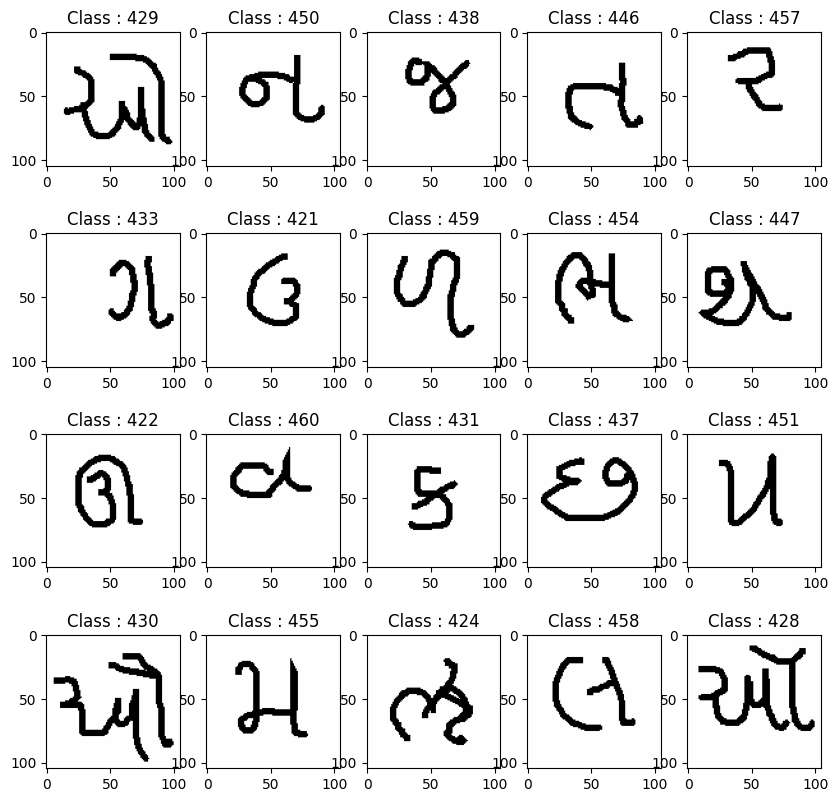

True Class is: 428
179.0
155.6
59.400000000000006
111.80000000000001
21.000000000000014
103.60000000000001
76.4
129.6
146.6
109.60000000000001
119.2
125.6
123.6
104.80000000000001
120.0
170.0
68.4
168.8
80.2
193.8
Predicted Class is 428


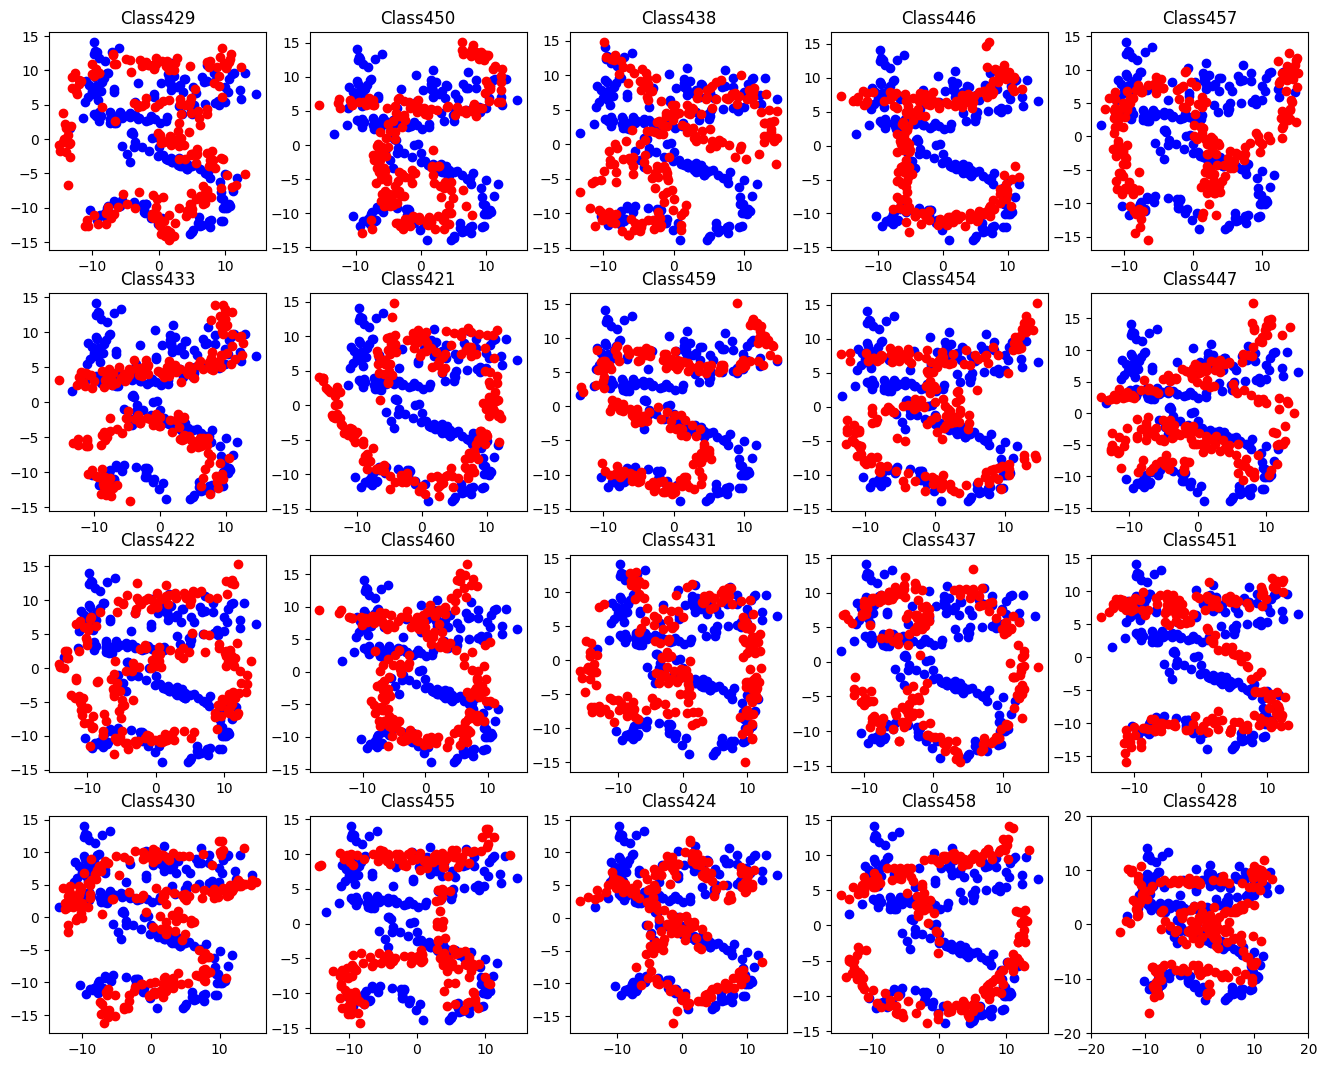

In [ ]:
density = 100
def visualize5():

  queries = []
  alphabet_id = np.random.randint(0,30)

  query,query_class,comparisons,selected_classes = oneshot_within(20 ,all_alphabets[alphabet_id], visual = True)
  final_scores = []
  fig2, axes2 = plt.subplots(nrows=4, ncols=5, figsize=(16.25, 13))
  ignore, query_gen = generate(pix2cart(query),10,density)

  query_trans = scale_shift(query_gen)
  print("True Class is:", query_class[0])

  for i, j in enumerate(comparisons):
    newlabels, cluster_j = generate(pix2cart(j), 10,density)

    xy1 = query_trans #final query before circles
    xy2 = scale_shift(cluster_j) #final comparison before circles
    ax2 = axes2[i // 5, i % 5]
    ax2.set_title("Class"+selected_classes[i])
    ax2.scatter(xy1[:, 0], xy1[:, 1], c="b")
    plt.xlim(-20, 20)
    plt.ylim(-20,20)
    ax2.scatter(xy2[:, 0], xy2[:, 1], c="r")
    plt.xlim(-20, 20)
    plt.ylim(-20,20)

    outliers = find_too_close(xy1,xy2,radius)
    print(outliers)
    final_scores.append(outliers)
  predicted_class = selected_classes[np.argmax(final_scores)]
  print("Predicted Class is", predicted_class)
  plt.show()



visualize5()